In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

import joblib  # for saving the model


In [9]:
# Load train and test datasets
test_df = pd.read_csv("C:/Users/neeth/Downloads/Logistic Regression/Logistic Regression/Titanic_test.csv")
train_df = pd.read_csv("C:/Users/neeth/Downloads/Logistic Regression/Logistic Regression/Titanic_train.csv")

# Display first few rows
print("Train Dataset:")
print(train_df.head())

print("\nTest Dataset:")
print(test_df.head())

# Info about data types and missing values
print("\n--- Train Dataset Info ---")
train_df.info()

print("\nSummary statistics:")
print(train_df.describe())

# Check missing values
print("\nMissing Values:\n", train_df.isnull().sum())


Train Dataset:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   Na

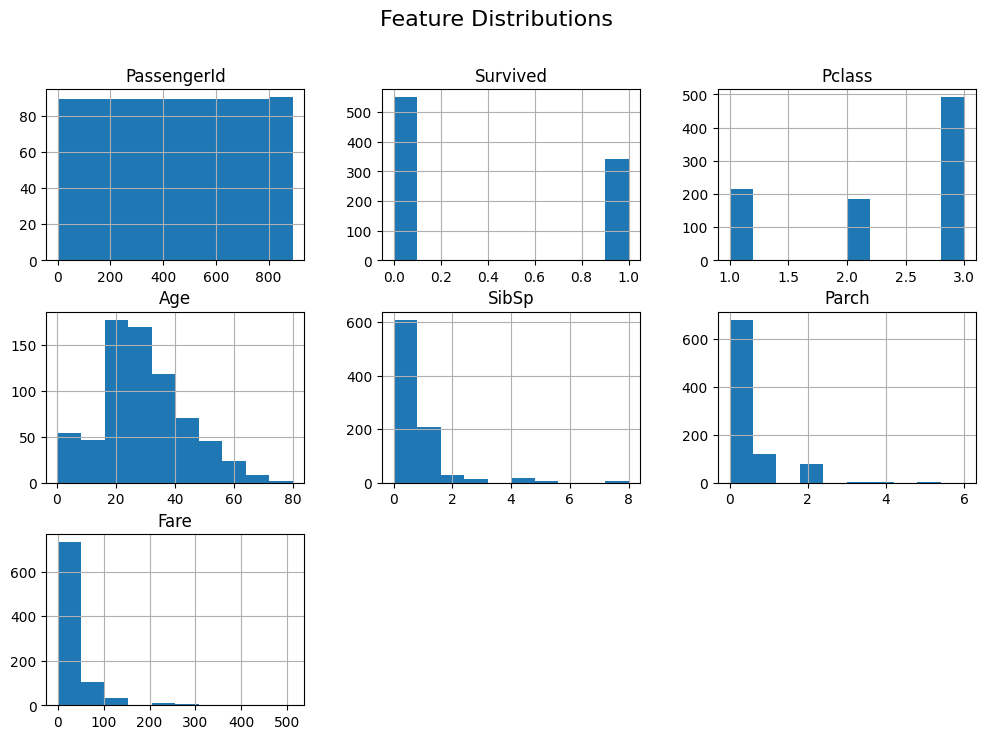

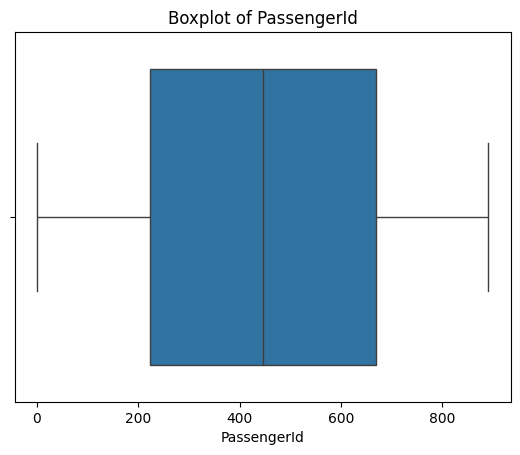

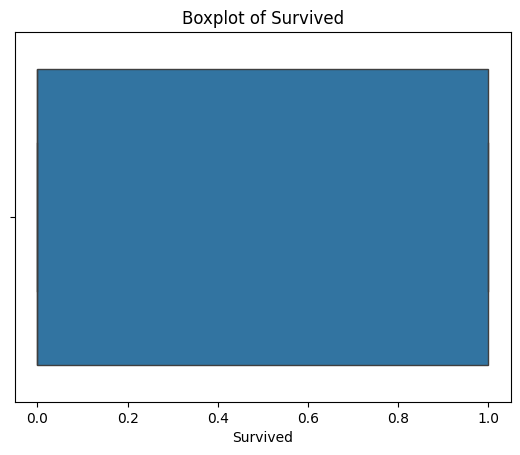

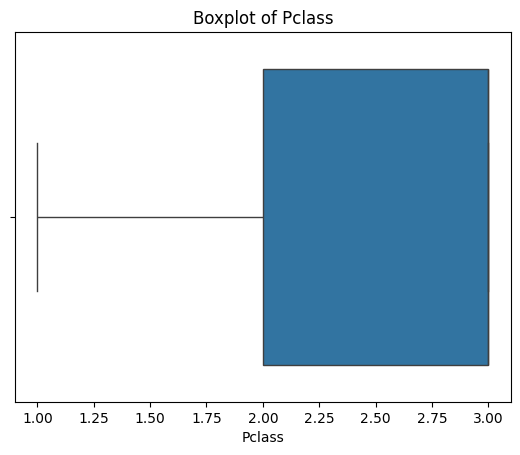

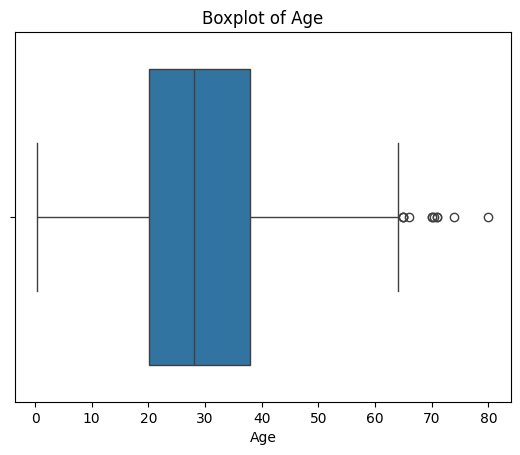

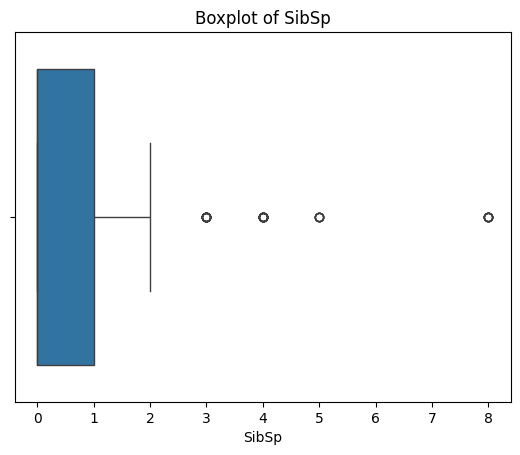

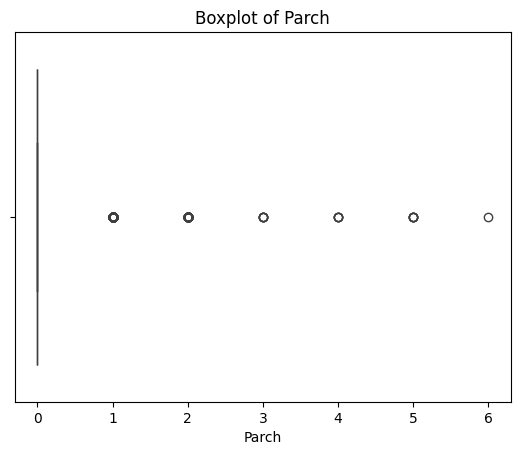

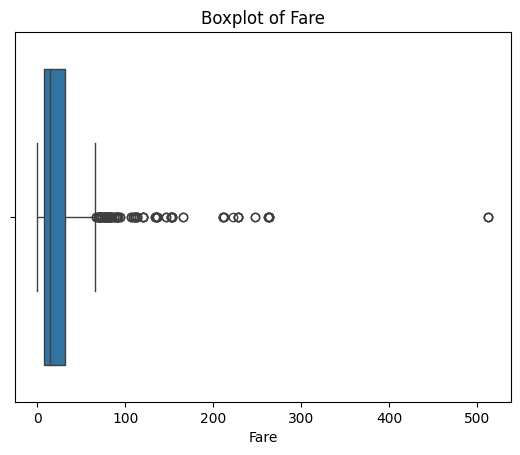

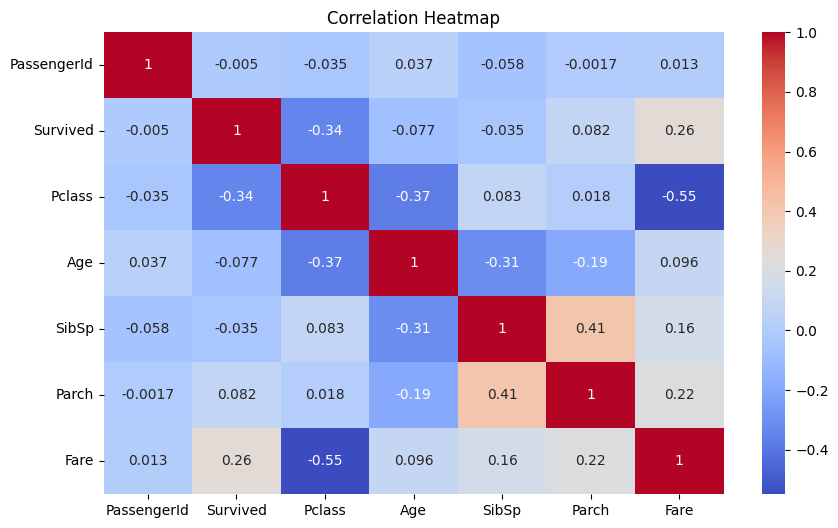

In [11]:
# Histograms for numerical columns
train_df.hist(figsize=(12, 8))
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# Box plots for outliers
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    plt.figure()
    sns.boxplot(data=train_df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.show()


# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [12]:
# Example for Titanic: Target is 'Survived'
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Numerical preprocessing: Impute missing with mean and scale
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: Impute missing with mode & One-hot encode
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])


In [13]:
# Split train data into train/test subsets for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Build pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train model
model.fit(X_train, y_train)

# Save model
joblib.dump(model, "logistic_model.pkl")
print("✅ Model trained and saved successfully!")


✅ Model trained and saved successfully!


Accuracy: 0.8212290502793296
Precision: 0.7936507936507936
Recall: 0.7246376811594203
F1 Score: 0.7575757575757576
ROC-AUC: 0.8533596837944665


c:\Users\neeth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\neeth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


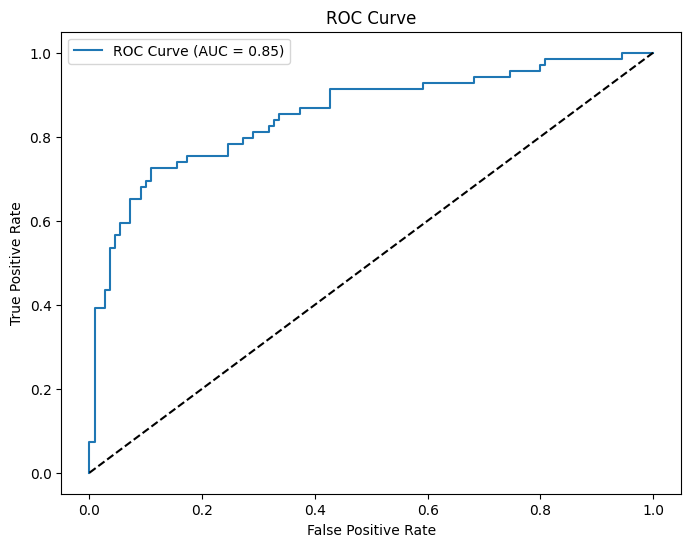

In [14]:
# Predictions
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_pred_proba))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_val, y_pred_proba):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [15]:
# Get feature names after one-hot encoding
feature_names = list(num_cols) + list(model.named_steps['preprocessor']
                                      .named_transformers_['cat']
                                      .named_steps['encoder']
                                      .get_feature_names_out(cat_cols))

# Get coefficients
coefficients = model.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance['Abs_Coeff'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Abs_Coeff', ascending=False)

print(feature_importance.head(10))

# Interpretation:
print("\nFeatures with positive coefficients increase survival probability,")
print("while those with negative coefficients decrease it.")


            Feature  Coefficient  Abs_Coeff
717        Sex_male    -2.709686   2.709686
783     Ticket_1601     1.994958   1.994958
997   Ticket_347077     1.026521   1.026521
1000  Ticket_347082    -0.994940   0.994940
1412       Cabin_G6    -0.962853   0.962853
1051  Ticket_349909    -0.938330   0.938330
921    Ticket_29106     0.880411   0.880411
1086  Ticket_367226     0.845687   0.845687
892     Ticket_2678    -0.835472   0.835472
1139    Ticket_7598     0.807988   0.807988

Features with positive coefficients increase survival probability,
while those with negative coefficients decrease it.
